# COMP 551 - Mini-project 4
Group 62

In [3]:
import keras
import numpy as np
%matplotlib inline                                 
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace  
import os

np.random.seed(1234)

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/Colab Notebooks/COMP551_mini_proj4/'
pathfig='/content/drive/My Drive/Colab Notebooks/COMP551_mini_proj4/figures'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## MNIST Dataset

In [5]:
# from keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape, y_train.shape)

# vectorize
x_train = np.reshape(x_train, (-1, 784)).astype('float32')
print(x_train.shape)

# normalize
print('Intensity before normalization:', np.amin(x_train), np.amax(x_train))
x_train = x_train/255.0
print('Intensity after normalization:', np.amin(x_train), np.amax(x_train))

# subset 2500 instances
data_slice = 2500
X = x_train[:data_slice,:]
labels = y_train[:data_slice]
print(X.shape, labels.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(60000, 784)
Intensity before normalization: 0.0 255.0
Intensity after normalization: 0.0 1.0
(2500, 784) (2500,)


## Code from the author

In [10]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 250:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 50:
            P = P / 4.

    # Return solution
    return Y

## t-SNE without PCA

In [7]:
def tsne_nopca(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    #X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 250:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 50:
            P = P / 4.

    # Return solution
    return Y

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 21.065856
Iteration 20: error is 19.520791
Iteration 30: error is 18.170122
Iteration 40: error is 17.659175
Iteration 50: error is 17.236923
Iteration 60: error is 2.463853
Iteration 70: error is 2.120577
Iteration 80: error is 1.913753
Iteration 90: error is 1.772126
Iteration 100: error is 1.667573
Iteration 110: error is 1.586363
Iteration 120: error is 1.521071
Iteration 130: error is 1.467389
Iteration 140: error is 1.422756
Iteration 150: error is 1.385377
Iteration 160: error is 1.354042
Iteration 170: error is 1.327215
Iteration 180: error is 1.303660
Iteration 190: error is 1.282910
Iteration 200: error is 1.264631
Iteration 210: error is 1.248375
Iteration 220: error is 1.23

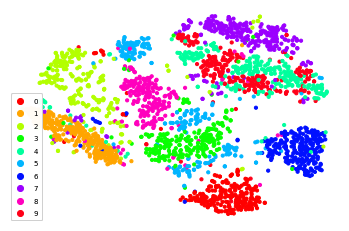

CPU times: user 7min 57s, sys: 1min 42s, total: 9min 40s
Wall time: 7min 46s


In [8]:
%%time
Y = tsne_nopca(X, 2, 50, 40)
fig, ax = plt.subplots()
scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
plt.axis('off')
legend = ax.legend(*scatter.legend_elements(), fontsize=7)
ax.add_artist(legend)
plt.savefig(os.path.join(pathfig,'tSNE_nopca.png'))
plt.show()

## Trying with PCA and with different dimensions values

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 0.637173
Iteration 10: error is 21.175838
Iteration 20: error is 18.342740
Iteration 30: error is 16.500862
Iteration 40: error is 15.585573
Iteration 50: error is 15.203300
Iteration 60: error is 2.076955
Iteration 70: error is 1.798005
Iteration 80: error is 1.618367
Iteration 90: error is 1.490813
Iteration 100: error is 1.395778
Iteration 110: error is 1.322972
Iteration 120: error is 1.265557
Iteration 130: error is 1.219137
Iteration 140: error is 1.180571
Iteration 150: error is 1.147985
Iteration 160: error is 1.121215
Iteration 170: error is 1.098507
Iteration 180: error is 1.079013
Iteration 190: error is 1.062142
Iteration 200: error is 1.047436
Iteration 210: error is 1

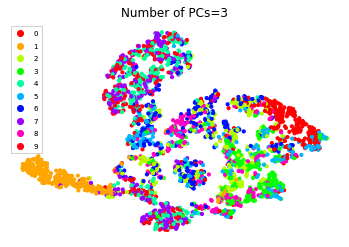

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 1.556902
Iteration 10: error is 20.978257
Iteration 20: error is 18.424563
Iteration 30: error is 16.970919
Iteration 40: error is 16.556760
Iteration 50: error is 16.349125
Iteration 60: error is 2.317449
Iteration 70: error is 2.022048
Iteration 80: error is 1.838824
Iteration 90: error is 1.711832
Iteration 100: error is 1.618130
Iteration 110: error is 1.547086
Iteration 120: error is 1.490916
Iteration 130: error is 1.444390
Iteration 140: error is 1.406098
Iteration 150: error is 1.374366
Iteration 160: error is 1.347427
Iteration 170: error is 1.324314
Iteration 180: error is 1.304326
Iteration 190: error is 1.286927
Iteration 200: error is 1.271679
Iteration 210: error is 1

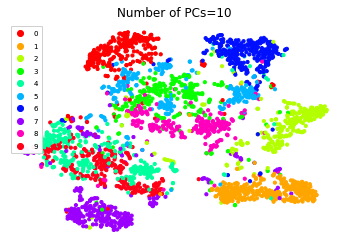

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 1.983720
Iteration 10: error is 21.142243
Iteration 20: error is 18.876582
Iteration 30: error is 17.142261
Iteration 40: error is 16.633397
Iteration 50: error is 16.366613
Iteration 60: error is 2.327045
Iteration 70: error is 2.033918
Iteration 80: error is 1.849426
Iteration 90: error is 1.720021
Iteration 100: error is 1.623580
Iteration 110: error is 1.548354
Iteration 120: error is 1.488297
Iteration 130: error is 1.438943
Iteration 140: error is 1.397441
Iteration 150: error is 1.362846
Iteration 160: error is 1.333492
Iteration 170: error is 1.308307
Iteration 180: error is 1.286657
Iteration 190: error is 1.267797
Iteration 200: error is 1.251204
Iteration 210: error is 1

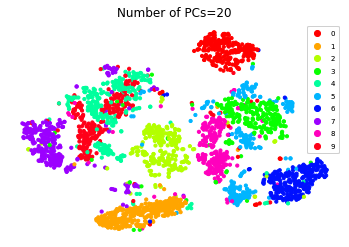

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.281416
Iteration 10: error is 21.006139
Iteration 20: error is 18.764058
Iteration 30: error is 17.366269
Iteration 40: error is 16.861015
Iteration 50: error is 16.575810
Iteration 60: error is 2.365161
Iteration 70: error is 2.061426
Iteration 80: error is 1.869638
Iteration 90: error is 1.734821
Iteration 100: error is 1.633829
Iteration 110: error is 1.554757
Iteration 120: error is 1.491691
Iteration 130: error is 1.440379
Iteration 140: error is 1.397805
Iteration 150: error is 1.362017
Iteration 160: error is 1.331549
Iteration 170: error is 1.305436
Iteration 180: error is 1.283103
Iteration 190: error is 1.263678
Iteration 200: error is 1.246476
Iteration 210: error is 1

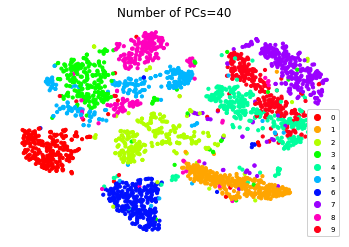

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.345902
Iteration 10: error is 21.123776
Iteration 20: error is 19.166845
Iteration 30: error is 17.557741
Iteration 40: error is 16.977515
Iteration 50: error is 16.668253
Iteration 60: error is 2.375634
Iteration 70: error is 2.062499
Iteration 80: error is 1.865171
Iteration 90: error is 1.726857
Iteration 100: error is 1.624523
Iteration 110: error is 1.545073
Iteration 120: error is 1.481806
Iteration 130: error is 1.430440
Iteration 140: error is 1.387613
Iteration 150: error is 1.351488
Iteration 160: error is 1.321107
Iteration 170: error is 1.295492
Iteration 180: error is 1.273334
Iteration 190: error is 1.253796
Iteration 200: error is 1.236418
Iteration 210: error is 1

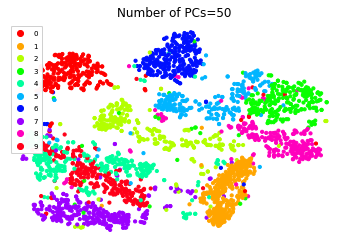

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.388516
Iteration 10: error is 21.205248
Iteration 20: error is 19.439135
Iteration 30: error is 17.817658
Iteration 40: error is 17.183971
Iteration 50: error is 16.849077
Iteration 60: error is 2.417395
Iteration 70: error is 2.096065
Iteration 80: error is 1.894370
Iteration 90: error is 1.753627
Iteration 100: error is 1.649039
Iteration 110: error is 1.568198
Iteration 120: error is 1.503846
Iteration 130: error is 1.451308
Iteration 140: error is 1.407593
Iteration 150: error is 1.370845
Iteration 160: error is 1.339901
Iteration 170: error is 1.313828
Iteration 180: error is 1.291167
Iteration 190: error is 1.271081
Iteration 200: error is 1.253228
Iteration 210: error is 1

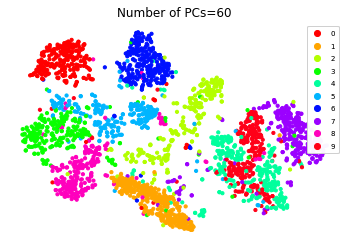

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.414868
Iteration 10: error is 21.143285
Iteration 20: error is 19.357815
Iteration 30: error is 17.741188
Iteration 40: error is 17.120006
Iteration 50: error is 16.808381
Iteration 60: error is 2.395969
Iteration 70: error is 2.082462
Iteration 80: error is 1.888523
Iteration 90: error is 1.753564
Iteration 100: error is 1.653254
Iteration 110: error is 1.575185
Iteration 120: error is 1.512028
Iteration 130: error is 1.460014
Iteration 140: error is 1.416667
Iteration 150: error is 1.380168
Iteration 160: error is 1.349642
Iteration 170: error is 1.323864
Iteration 180: error is 1.301380
Iteration 190: error is 1.281472
Iteration 200: error is 1.263916
Iteration 210: error is 1

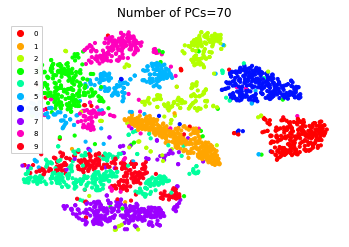

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.449879
Iteration 10: error is 21.133522
Iteration 20: error is 19.344486
Iteration 30: error is 17.826392
Iteration 40: error is 17.287542
Iteration 50: error is 16.930380
Iteration 60: error is 2.414189
Iteration 70: error is 2.089823
Iteration 80: error is 1.891358
Iteration 90: error is 1.752943
Iteration 100: error is 1.650258
Iteration 110: error is 1.570504
Iteration 120: error is 1.506979
Iteration 130: error is 1.454854
Iteration 140: error is 1.411318
Iteration 150: error is 1.374818
Iteration 160: error is 1.344335
Iteration 170: error is 1.318393
Iteration 180: error is 1.295813
Iteration 190: error is 1.275830
Iteration 200: error is 1.258165
Iteration 210: error is 1

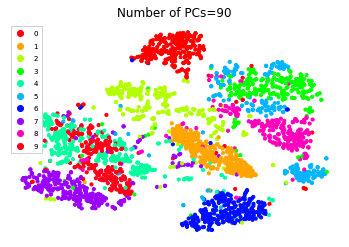

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.460355
Iteration 10: error is 20.977618
Iteration 20: error is 18.840137
Iteration 30: error is 17.559959
Iteration 40: error is 17.095762
Iteration 50: error is 16.838180
Iteration 60: error is 2.400171
Iteration 70: error is 2.077340
Iteration 80: error is 1.880191
Iteration 90: error is 1.744067
Iteration 100: error is 1.643054
Iteration 110: error is 1.564647
Iteration 120: error is 1.501444
Iteration 130: error is 1.449286
Iteration 140: error is 1.405594
Iteration 150: error is 1.369247
Iteration 160: error is 1.338864
Iteration 170: error is 1.313087
Iteration 180: error is 1.290469
Iteration 190: error is 1.270423
Iteration 200: error is 1.252646
Iteration 210: error is 1

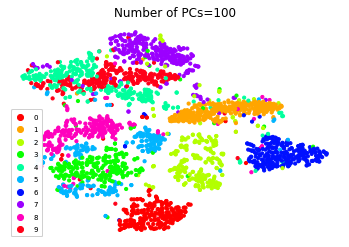

CPU times: user 1h 11min 35s, sys: 15min 27s, total: 1h 27min 3s
Wall time: 1h 9min 38s


In [14]:
%%time
dims = [3,10,20,40,50,60,70,90,100]

for d in dims:
  Y = tsne(X, no_dims=2, initial_dims=d, perplexity=40.0)
  fig, ax = plt.subplots()
  scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
  plt.axis('off')
  legend = ax.legend(*scatter.legend_elements(), fontsize=7)
  ax.add_artist(legend)
  plt.title('Number of PCs='+str(d))
  plt.savefig(os.path.join(pathfig,('tSNE_'+str(d)+'PCs.png')))
  plt.show()